# NEURAL NETWORK


In [1]:
if False:
    fig = FigureWidgetResampler(go.Figure())
    fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
    fig.add_trace(go.Scattergl(name=r'Height', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['height'])
    fig.add_trace(go.Scattergl(name=r'Outflow', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['outflow'])
    fig.add_trace(go.Scattergl(name=r'pump1_rpm', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump1_rpm'])
    fig.add_trace(go.Scattergl(name=r'pump1_power', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump1_power'])
    fig.add_trace(go.Scattergl(name=r'pump4_rpm', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump4_rpm'])
    fig.add_trace(go.Scattergl(name=r'pump4_power', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump4_power'])
    fig.update_layout(height=400, template="plotly_dark")
    display(fig)

### Fit & Predict (TARGET = HEIGHT, FEATURE = OUTFLOW)

In [2]:
import numpy as np
import pandas as pd

from sysidentpy.metrics import mean_squared_error
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
from sysidentpy.utils.display_results import results
from plotly_resampler import FigureResampler, FigureWidgetResampler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
torch.manual_seed(0)

pump_station_data = pd.read_parquet("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")

pump_station_data_resampled = pump_station_data.resample("1T").mean()

pump_station_data_resampled_pump1on = pump_station_data_resampled[(pump_station_data_resampled["pump1_rpm"] > 0) & (pump_station_data_resampled["pump4_rpm"] == 0)]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pump_station_data_resampled_pump1on)
df_scaled = pd.DataFrame(scaled_data, columns=pump_station_data_resampled_pump1on.columns, index=pump_station_data_resampled_pump1on.index)

train = df_scaled.loc["2023-01-27":"2023-01-30"]
test = df_scaled.loc["2023-02-27":"2023-03-02"] 


In [3]:

#FEATURES = ['height', 'outflow']
FEATURES = "outflow"
TARGET = 'height'

x_train, y_train = train[FEATURES].values.reshape(-1,1), train[TARGET].values.reshape(-1,1)
x_test, y_test= test[FEATURES].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=6,
    xlag=6,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    #optimizer="sgd",
    epochs=11,
    learning_rate = 4e-3,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    }, 
)
### Building the network

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(12, 100)
        self.lin2 = nn.Linear(100, 100)
        #self.lina = nn.Linear(100, 100)
        #self.linb = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, 1)
        self.tanh = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        #z = self.lina(z)
        #z = self.tanh(z)
        #z = self.linb(z)
        #z = self.tanh(z)
        z = self.lin3(z)
        return z
    

### Passing the defined network to our NARXNN estimator
narx_net.net = NARX()
if device == "cuda": narx_net.net.to(torch.device("cuda"))

Using cpu device


In [5]:
narx_net.fit(X=x_train, y=y_train.reshape(-1,1))
#narx_net.fit(X=x_train.reshape(-1,1), y=y_train.reshape(-1,1), X_test=x_test.reshape(-1,1), y_test=y_test.reshape(-1,1))

In [6]:
#yhat = narx_net.predict(X=x_test.reshape(-1,1), y=y_test.reshape(-1,1))
yhat = narx_net.predict(X=x_test, y=y_test.reshape(-1,1))
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  0.006390250926396184


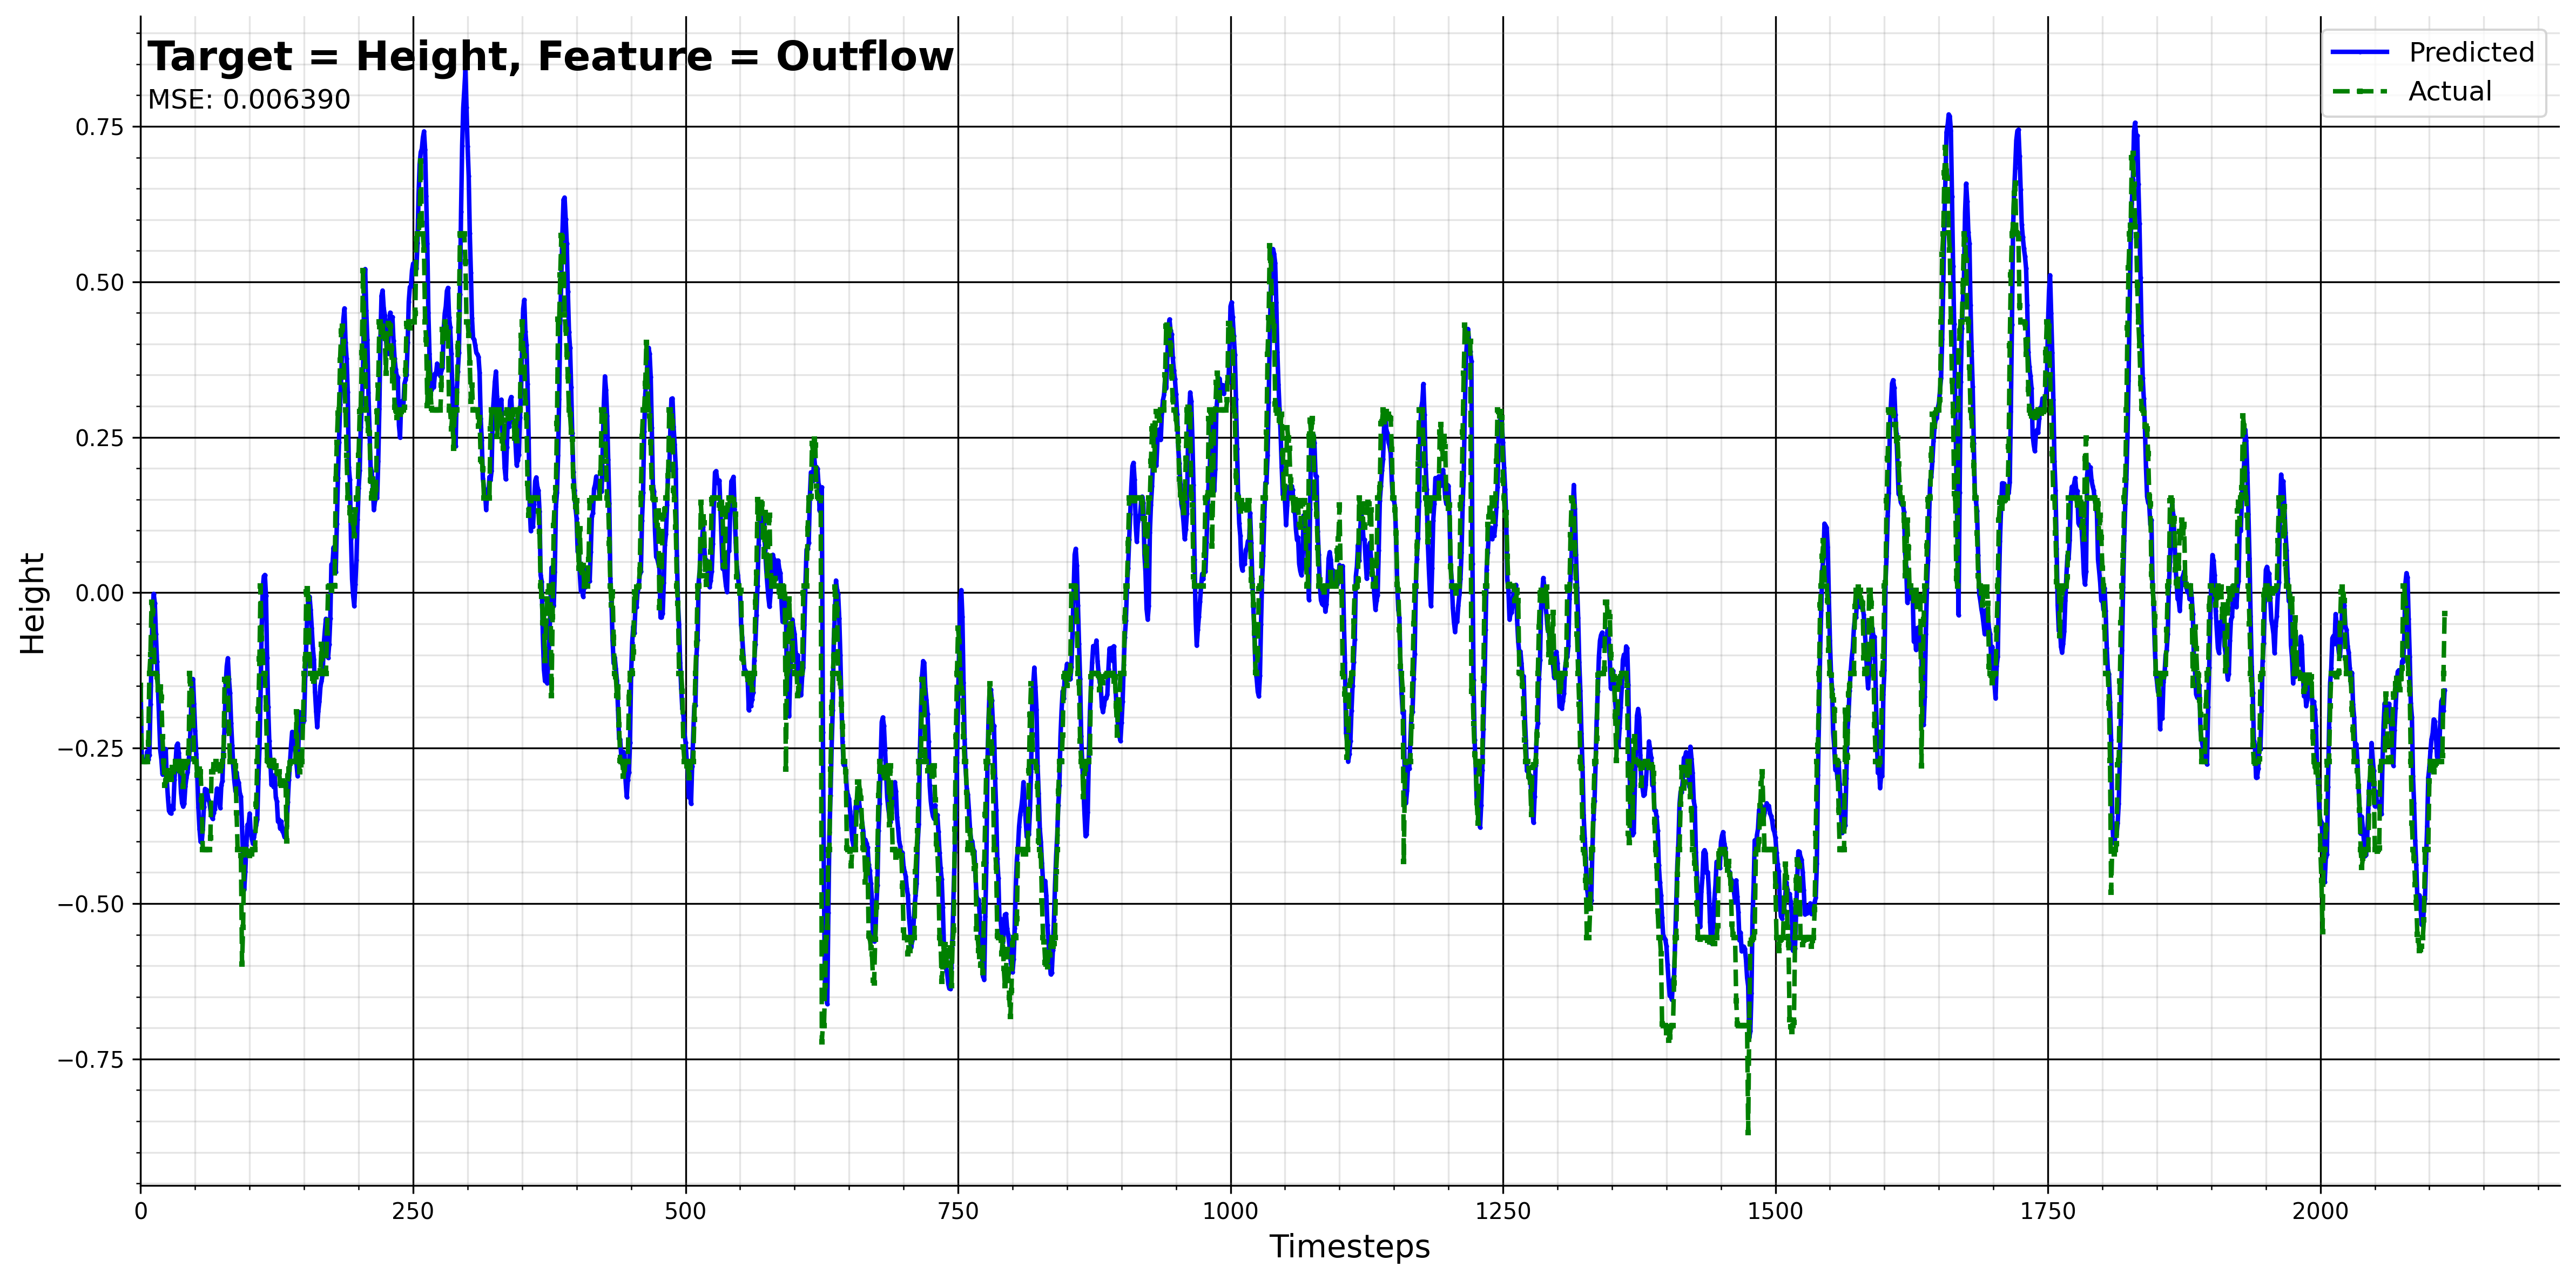

In [7]:
import matplotlib.pyplot as plt 
plt.figure(1, dpi = 300, figsize=(16,8))
plt.plot(yhat, color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test, color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.figtext(0.06,0.94,"Target = Height, Feature = Outflow", fontsize=18, ha='left', weight='bold') #TITLE
plt.figtext(0.06,0.91,f'MSE: {mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)):.6f}',fontsize=12,ha='left') #SUBTITLE
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Height', fontsize=14)
plt.xlim(0)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()
plt.grid(which='major', color='k', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='-', alpha=0.2)
plt.minorticks_on()

# Show the plot
#plt.show()
plt.savefig('NN1.png', transparent=True)

MSE:  0.006390250926396184


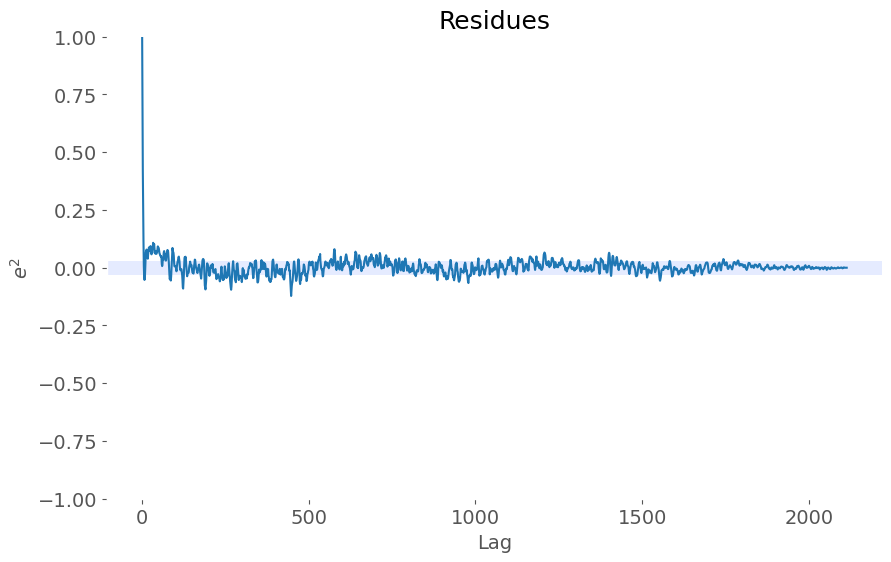

In [8]:
print("MSE: ", mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)))
#plot_results(y=y_test.reshape(-1,1), yhat=yhat.reshape(-1,1), n=1000, style='ggplot')
ee = compute_residues_autocorrelation(y_test.reshape(-1,1), yhat.reshape(-1,1))
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$", style='ggplot')
#x1e = compute_cross_correlation(y_test.reshape(-1,1), yhat.reshape(-1,1), x_test.reshape(-1,1))
#plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$", style='ggplot')

### Fit & Predict (TARGET = OUTFLOW, FEATURE = P1 RPM)

In [9]:
FEATURES = "pump1_rpm"
TARGET = 'outflow'

x_train, y_train = train[FEATURES].values.reshape(-1,1), train[TARGET].values.reshape(-1,1)
x_test, y_test= test[FEATURES].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)



In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=6,
    xlag=6,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    #optimizer="sgd",
    epochs=11,
    learning_rate = 4e-3,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    }, 
)
### Building the network

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(12, 100)
        self.lin2 = nn.Linear(100, 100)
        #self.lina = nn.Linear(100, 100)
        #self.linb = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, 1)
        self.tanh = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        #z = self.lina(z)
        #z = self.tanh(z)
        #z = self.linb(z)
        #z = self.tanh(z)
        z = self.lin3(z)
        return z
    

### Passing the defined network to our NARXNN estimator
narx_net.net = NARX()
if device == "cuda": narx_net.net.to(torch.device("cuda"))

Using cpu device


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=6,
    xlag=6,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    #optimizer="sgd",
    epochs=11,
    learning_rate = 4e-3,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    }, 
)
### Building the network

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(12, 100)
        self.lin2 = nn.Linear(100, 100)
        #self.lina = nn.Linear(100, 100)
        #self.linb = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, 1)
        self.tanh = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        #z = self.lina(z)
        #z = self.tanh(z)
        #z = self.linb(z)
        #z = self.tanh(z)
        z = self.lin3(z)
        return z
    

### Passing the defined network to our NARXNN estimator
narx_net.net = NARX()
if device == "cuda": narx_net.net.to(torch.device("cuda"))

Using cpu device


In [12]:
narx_net.fit(X=x_train, y=y_train.reshape(-1,1))
#narx_net.fit(X=x_train.reshape(-1,1), y=y_train.reshape(-1,1), X_test=x_test.reshape(-1,1), y_test=y_test.reshape(-1,1))

In [13]:
#yhat = narx_net.predict(X=x_test.reshape(-1,1), y=y_test.reshape(-1,1))
yhat = narx_net.predict(X=x_test, y=y_test.reshape(-1,1))
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  0.050237366469723294


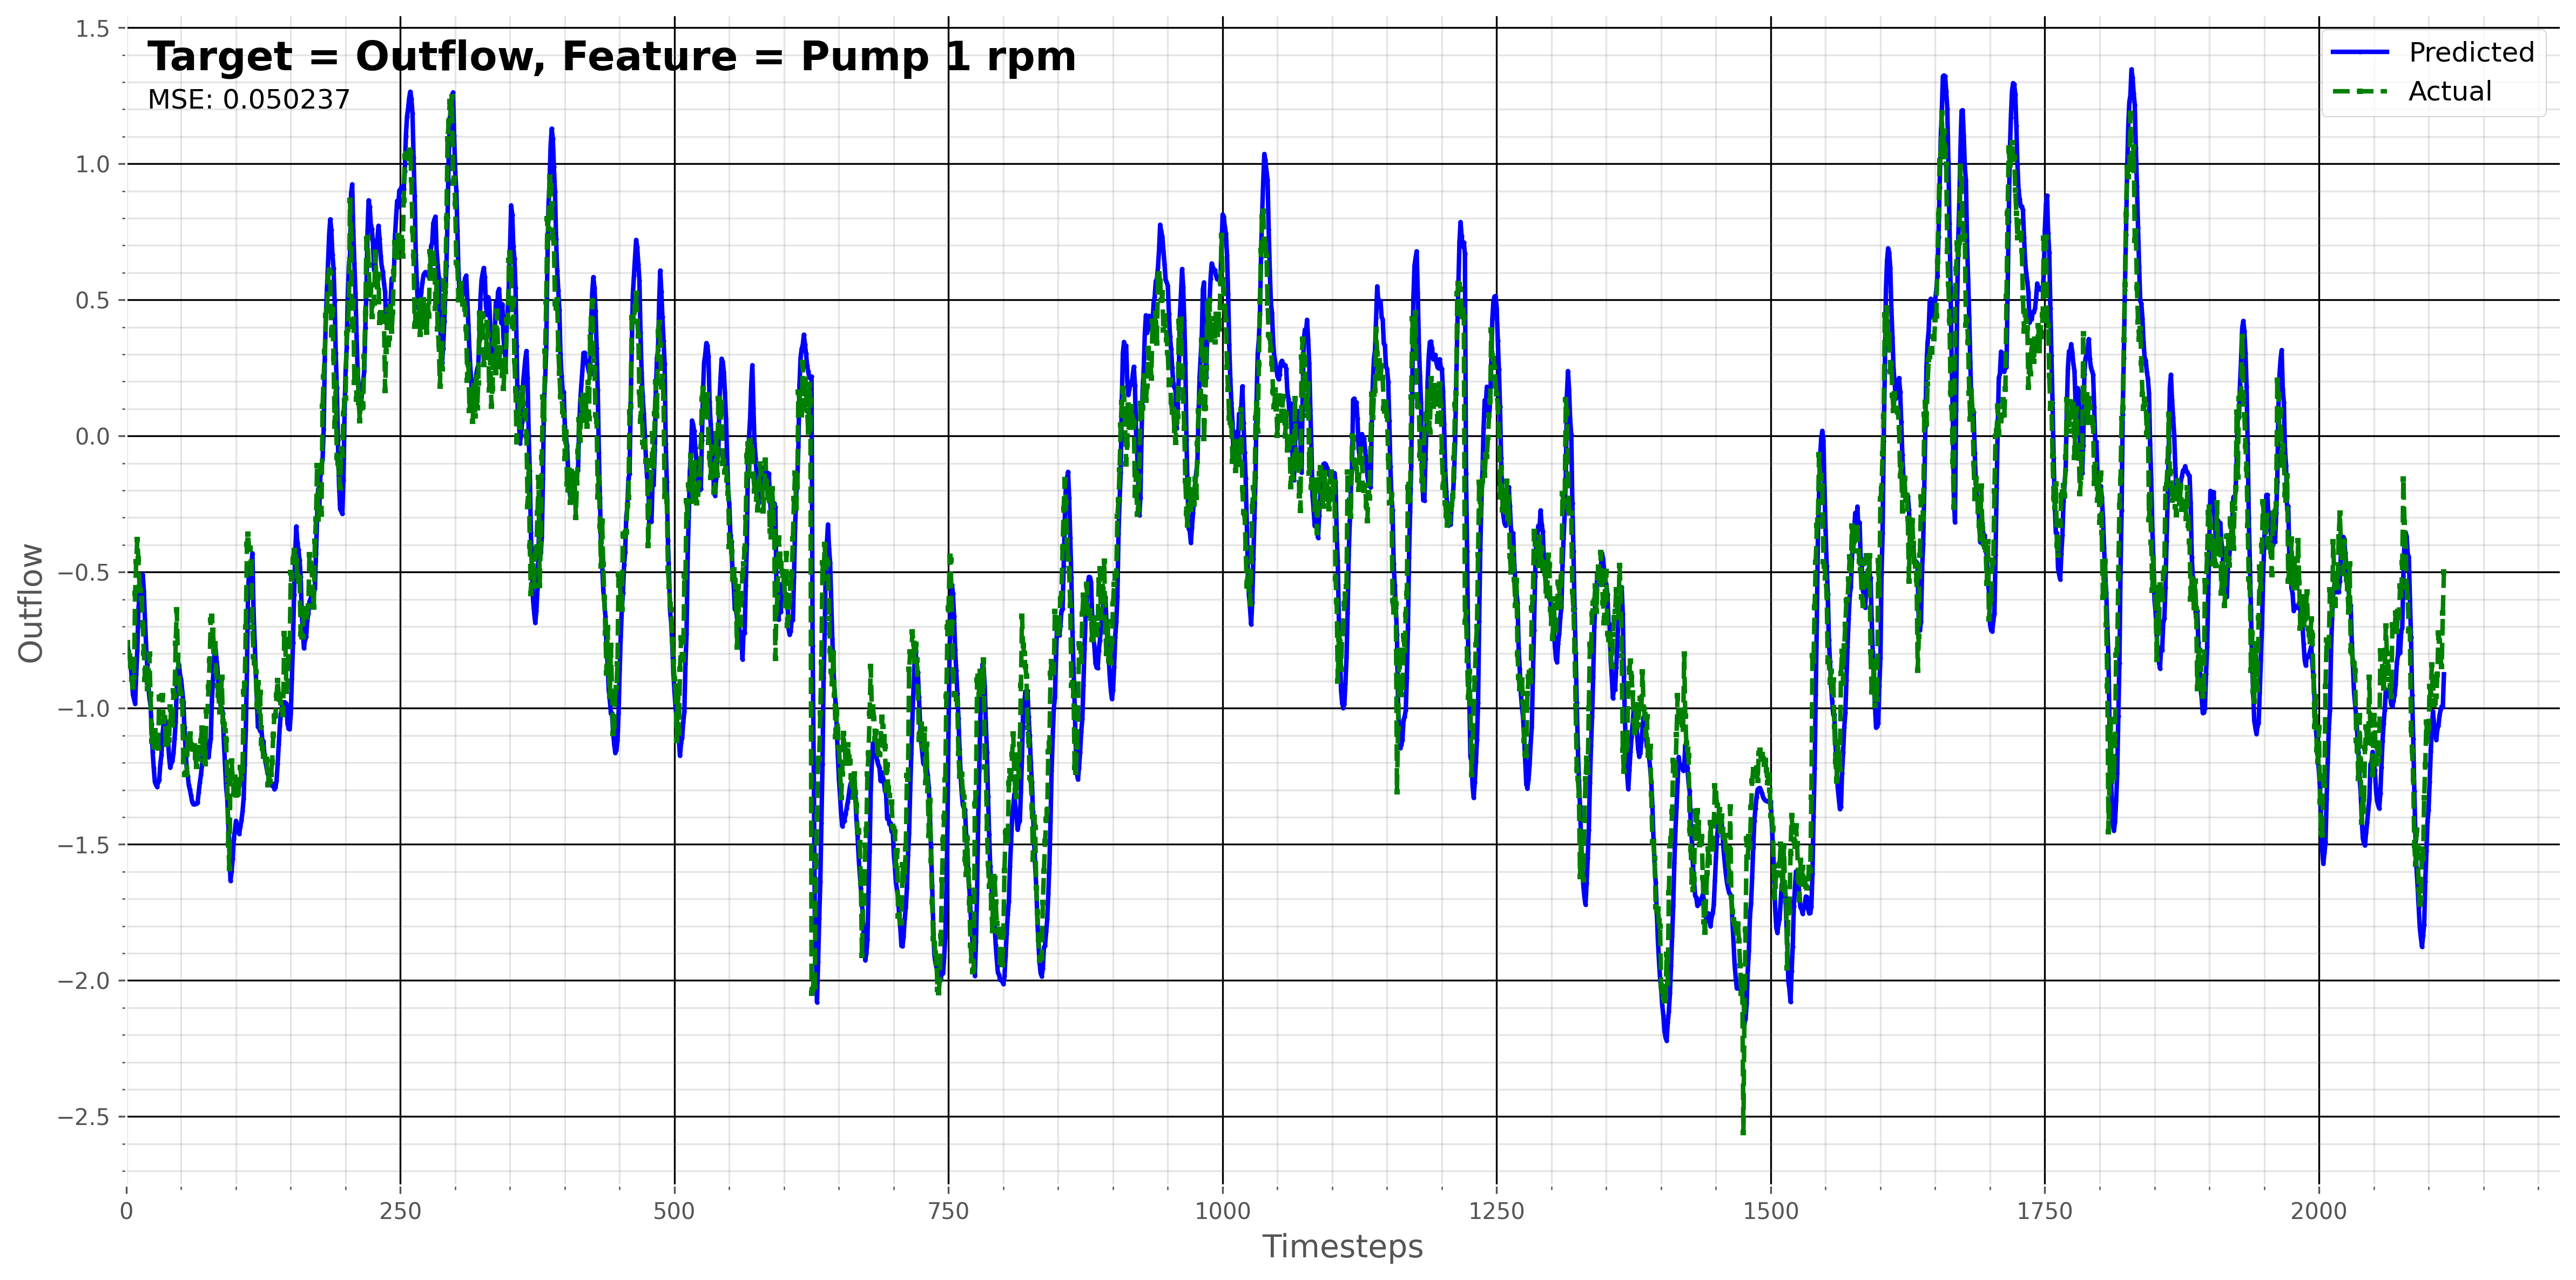

In [14]:
import matplotlib.pyplot as plt 
plt.figure(2, dpi = 300, figsize=(16,8))
plt.plot(yhat, color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test, color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.figtext(0.06,0.94,"Target = Outflow, Feature = Pump 1 rpm", fontsize=18, ha='left', weight='bold') #TITLE
plt.figtext(0.06,0.91,f'MSE: {mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)):.6f}',fontsize=12,ha='left') #SUBTITLE
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Outflow', fontsize=14)
plt.xlim(0)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()
plt.grid(which='major', color='k', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='-', alpha=0.2)
plt.minorticks_on()

# Show the plot
#plt.show()
plt.savefig('NN2.png', transparent=True)

MSE:  0.050237366469723294


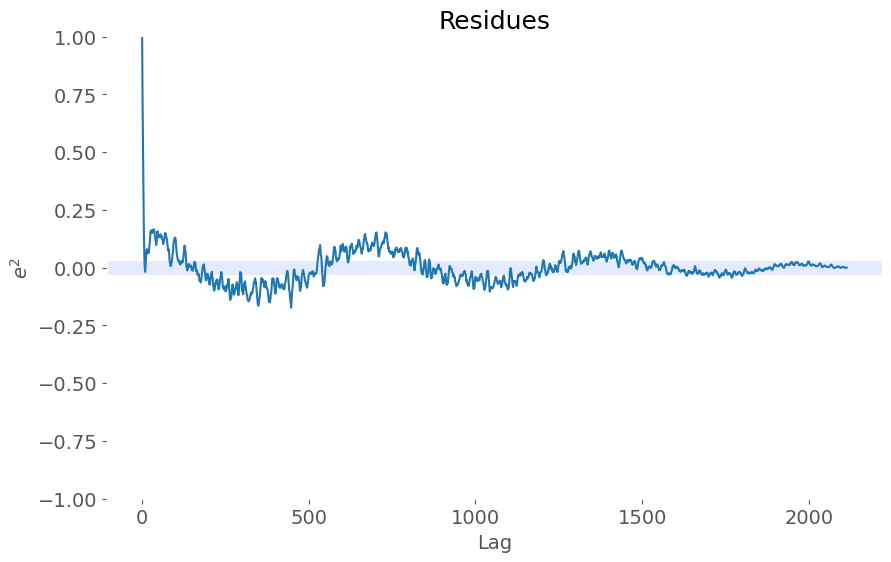

In [15]:
print("MSE: ", mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)))
#plot_results(y=y_test.reshape(-1,1), yhat=yhat.reshape(-1,1), n=1000, style='ggplot')
ee = compute_residues_autocorrelation(y_test.reshape(-1,1), yhat.reshape(-1,1))
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$", style='ggplot')
#x1e = compute_cross_correlation(y_test.reshape(-1,1), yhat.reshape(-1,1), x_test.reshape(-1,1))
#plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$", style='ggplot')

## INFLOW OUTFLOW

In [35]:
inflow_data = pd.read_csv("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/InflowData.csv")

inflow_data = inflow_data["0"]

pump_station_data = pd.read_parquet("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")

pump_station_data.insert(2, "inflow", inflow_data.values, True)

pump_station_data_w_inflow_resampled = pump_station_data.resample("1T").mean()

#pump_station_data_w_inflow_resampled_pump1on = pump_station_data_w_inflow_resampled[(pump_station_data_w_inflow_resampled["pump1_rpm"] > 0) & (pump_station_data_w_inflow_resampled["pump4_rpm"] == 0)]


In [36]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pump_station_data_w_inflow_resampled)
df_scaled = pd.DataFrame(scaled_data, columns=pump_station_data_w_inflow_resampled.columns, index=pump_station_data_w_inflow_resampled.index)

train = df_scaled.loc["2023-01-27":"2023-01-30"]
test = df_scaled.loc["2023-02-27":"2023-03-02"] 

#FEATURES = ['height', 'outflow']
FEATURES = "inflow"
TARGET = 'outflow'

x_train, y_train = train[FEATURES].values.reshape(-1,1), train[TARGET].values.reshape(-1,1)
x_test, y_test= test[FEATURES].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=6,
    xlag=6,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    #optimizer="sgd",
    epochs=9,
    learning_rate = 0.004,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    }, 
)
### Building the network

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(12, 100)
        self.lin2 = nn.Linear(100, 100)
        #self.lina = nn.Linear(100, 100)
        #self.linb = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, 1)
        self.tanh = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        #z = self.lina(z)
        #z = self.tanh(z)
        #z = self.linb(z)
        #z = self.tanh(z)
        z = self.lin3(z)
        return z
    

### Passing the defined network to our NARXNN estimator
narx_net.net = NARX()
if device == "cuda": narx_net.net.to(torch.device("cuda"))

Using cpu device


In [38]:
narx_net.fit(X=x_train.reshape(-1,1), y=y_train.reshape(-1,1))
#narx_net.fit(X=x_train.reshape(-1,1), y=y_train.reshape(-1,1), X_test=x_test.reshape(-1,1), y_test=y_test.reshape(-1,1))

In [39]:
#yhat = narx_net.predict(X=x_test.reshape(-1,1), y=y_test.reshape(-1,1))
yhat = narx_net.predict(X=x_test, y=y_test.reshape(-1,1))
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  0.040811262493851364


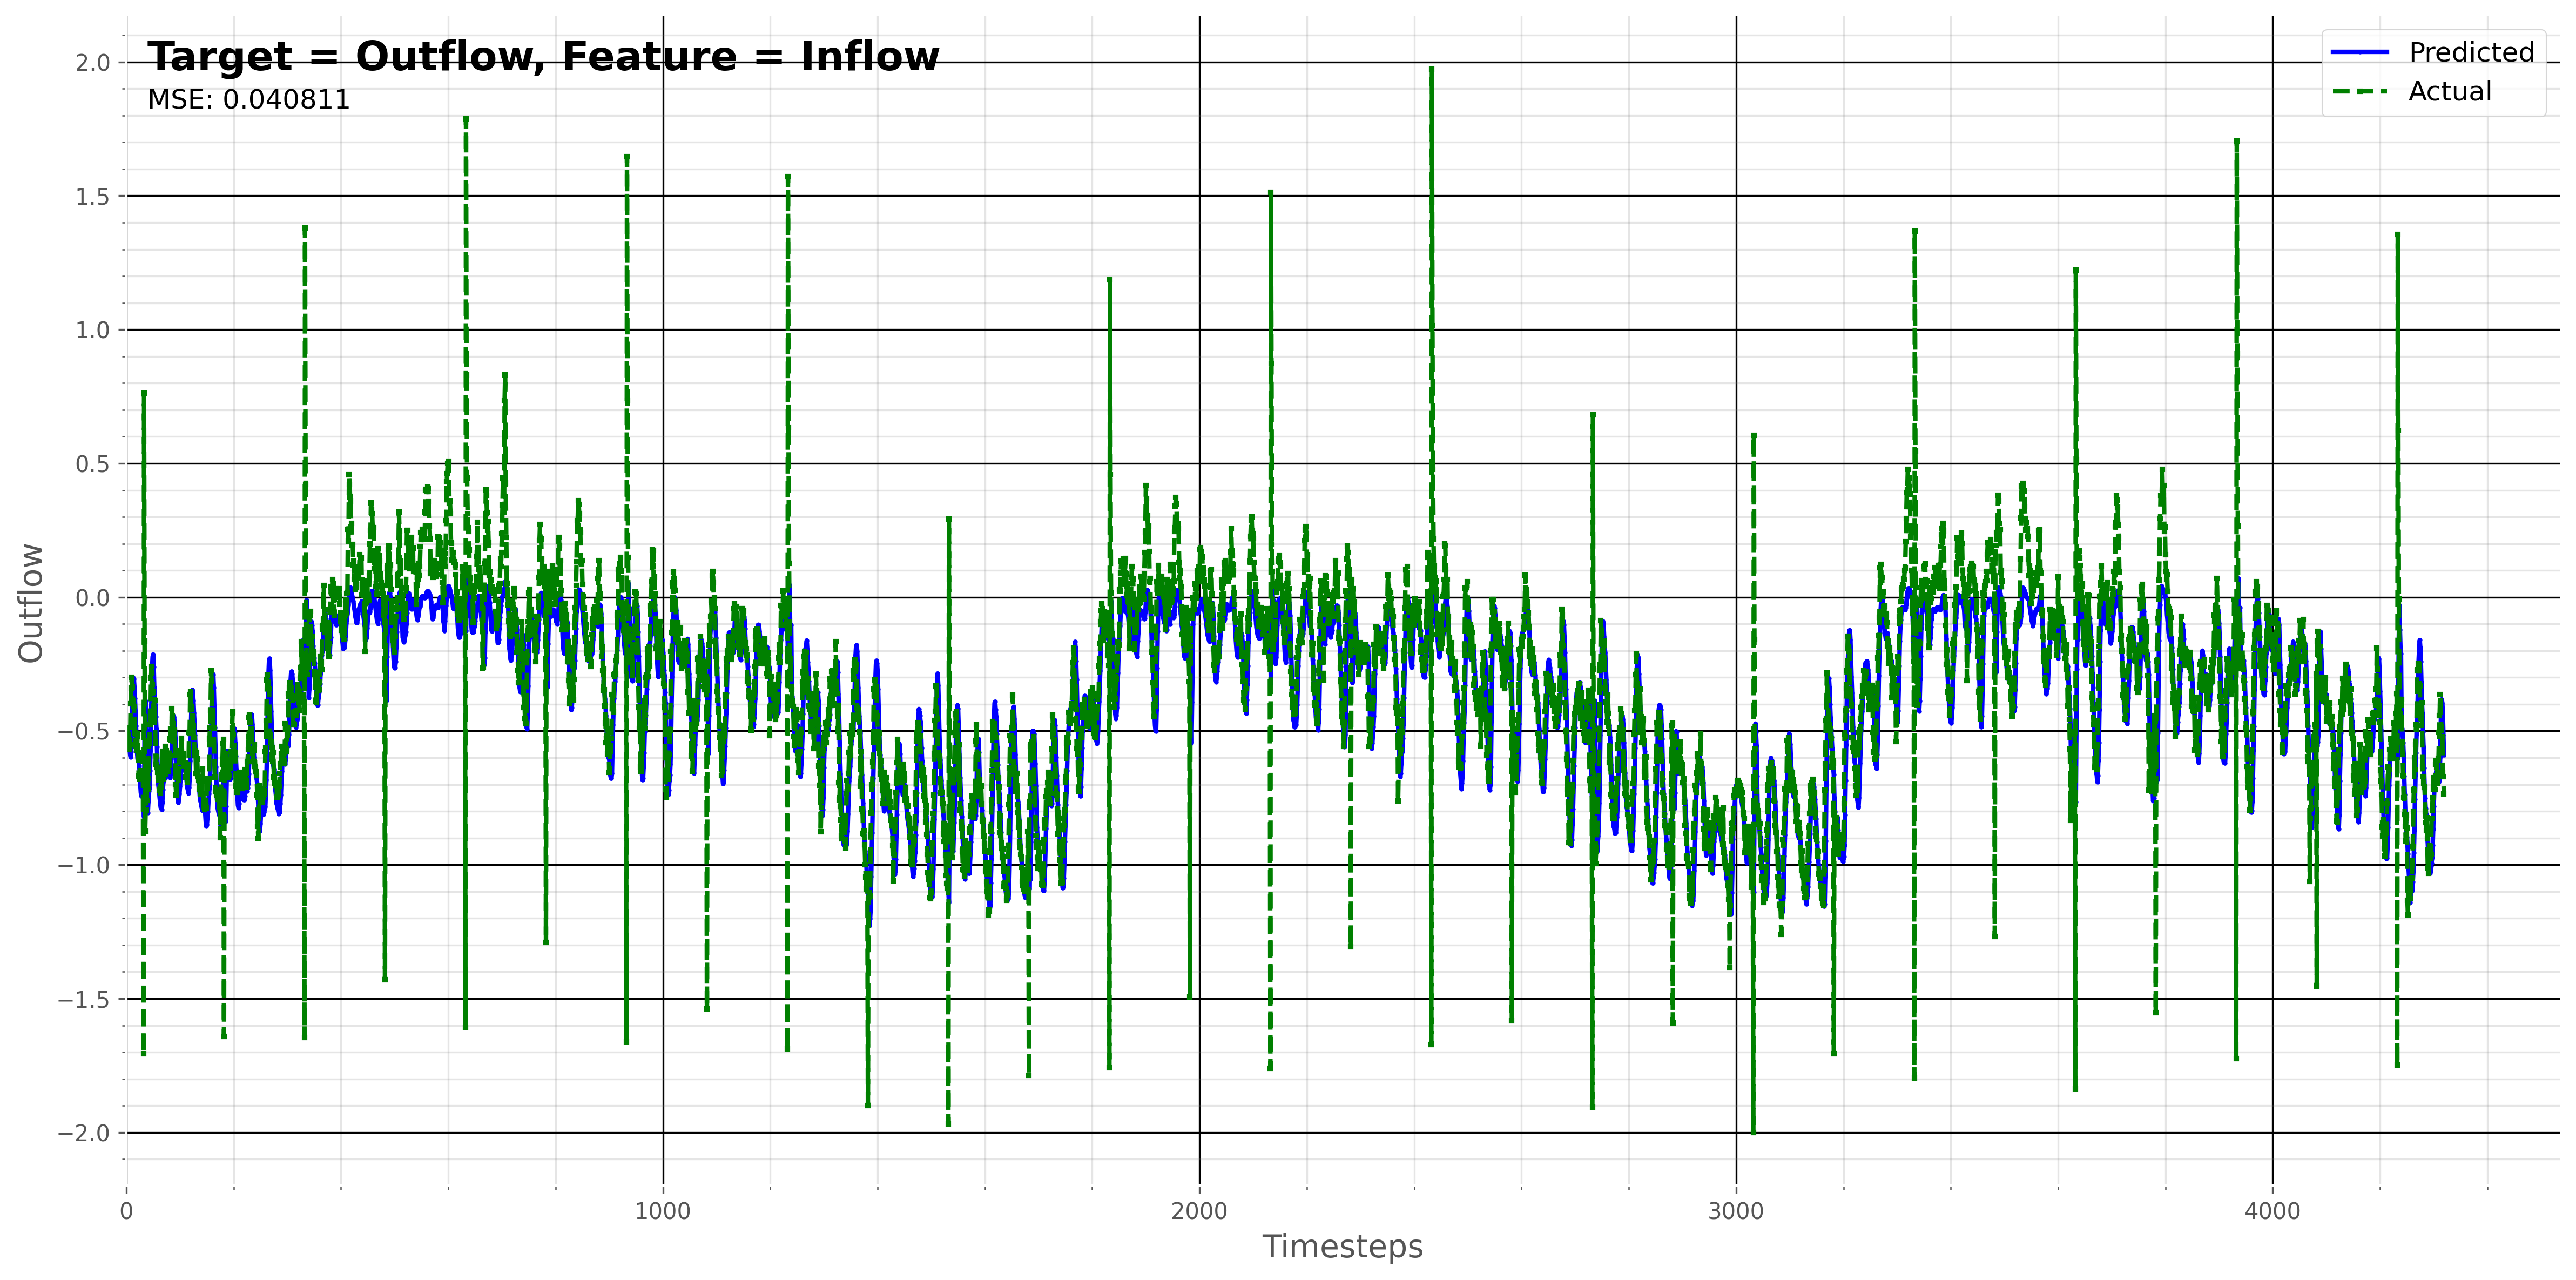

In [40]:
import matplotlib.pyplot as plt 
plt.figure(3, dpi = 300, figsize=(16,8))
plt.plot(yhat, color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test, color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.figtext(0.06,0.94,"Target = Outflow, Feature = Inflow", fontsize=18, ha='left', weight='bold') #TITLE
plt.figtext(0.06,0.91,f'MSE: {mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)):.6f}',fontsize=12,ha='left') #SUBTITLE
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Outflow', fontsize=14)
plt.xlim(0)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()
plt.grid(which='major', color='k', linestyle='-')
plt.grid(which='minor', color='gray', linestyle='-', alpha=0.2)
plt.minorticks_on()
# Show the plot
#plt.show()

plt.savefig('NN3.png', transparent=True)

MSE:  0.040811262493851364


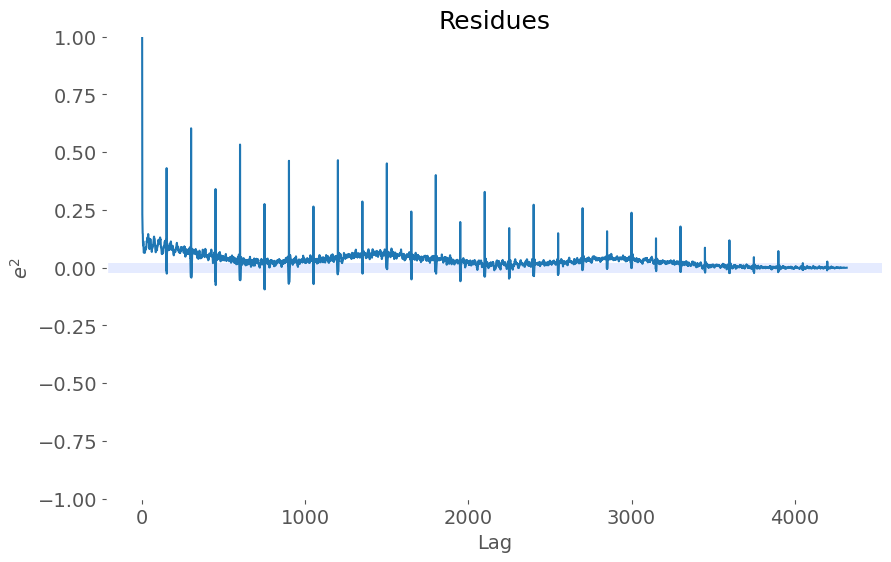

In [41]:
print("MSE: ", mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)))
#plot_results(y=y_test.reshape(-1,1), yhat=yhat.reshape(-1,1), n=1000, style='ggplot')
ee = compute_residues_autocorrelation(y_test.reshape(-1,1), yhat.reshape(-1,1))
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$", style='ggplot')
#x1e = compute_cross_correlation(y_test.reshape(-1,1), yhat.reshape(-1,1), x_test.reshape(-1,1))
#plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$", style='ggplot')